In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xval, Yval = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP 
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g) 


parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [6]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.8138
  20000/ 200000: 2.5218
  30000/ 200000: 2.7874
  40000/ 200000: 2.0334
  50000/ 200000: 2.6237
  60000/ 200000: 2.3289
  70000/ 200000: 2.0826
  80000/ 200000: 2.2784
  90000/ 200000: 2.2252
 100000/ 200000: 2.0428
 110000/ 200000: 2.3121
 120000/ 200000: 2.0570
 130000/ 200000: 2.4546
 140000/ 200000: 2.2233
 150000/ 200000: 2.1551
 160000/ 200000: 2.0597
 170000/ 200000: 1.7981
 180000/ 200000: 2.0194
 190000/ 200000: 1.7459


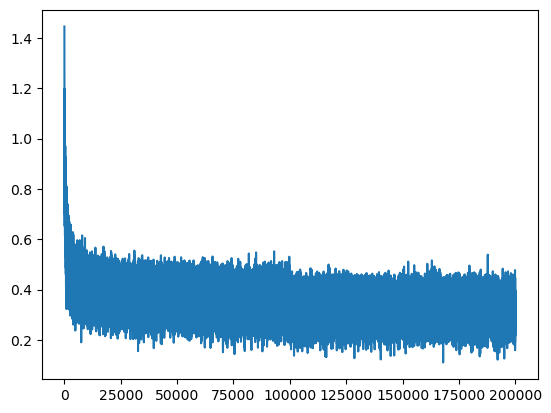

In [7]:
plt.plot(lossi)
plt.show()

In [12]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "validation": (Xval, Yval),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("validation")

train loss: 2.1267659664154053
validation loss: 2.1697638034820557


In [13]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]              # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1)                # concatenate the vectors
        h = torch.tanh(x @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))              # decode and print the generated word

carlah.
amorie.
khirmin.
rey.
cassanden.
jazhubedah.
sart.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
jore.
quint.
salin.
alianni.
wazthoniearyxi.
jace.
pirran.
eddeci.


In [14]:
#
# Fix the initial loss
#

In [ ]:
# 1 / 27 ≈ 0.037037
# log(1/27) ≈ -3.2958
# - log(1/27) = 3.2958
# Model behavior	Probability for correct char	Loss (−log p)
# perfect (100% confident),	1.0,	0.0
# good (p=0.5),	0.5,	0.693
# random (uniform over 27 chars),	1/27 ≈ 0.037,	3.296
# terrible (p=0.001),	0.001,	6.9

In [18]:
expected_loss = - torch.tensor(1 / 27).log()
print(expected_loss)

tensor(3.2958)


In [19]:
# 4-dimensional example of the issue
logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
#logits = torch.rand(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -1 * torch.log(probs[2])
#loss = -probs[2].log()
logits, probs, loss

(tensor([1., 1., 1., 1.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [21]:

#emb → (flatten) → W1,b1 → tanh → W2,b2 → logits
# small init value for output layer -- get rid of hokey shape
# last layer -- very small value; hidden layer -- kaiming init

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
block_size = 3
# vocab_size = 27

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [22]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


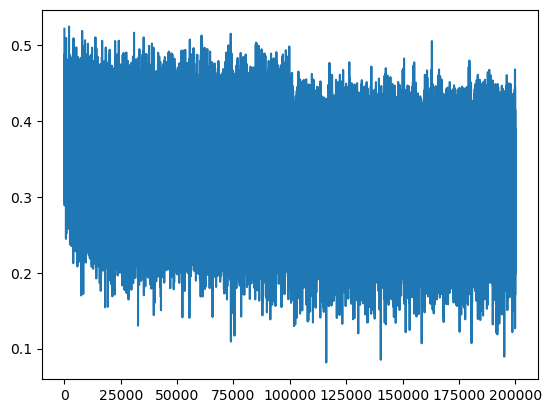

In [23]:
plt.plot(lossi)
plt.show()

In [ ]:
# NO hockey stick shape, as W2 and b2 are small 

In [25]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "dev": (Xval, Yval),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("dev")

train loss: 2.0695888996124268
dev loss: 2.131074905395508


In [26]:
# pre logits init fix:
# train loss: 2.1267659664154053
# validation loss: 2.1697638034820557
# post logits init fix:
# train loss: 2.0695888996124268
# dev loss: 2.131074905395508

In [27]:
#
# Fix satuarted tanh
# 

In [28]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [29]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3221


In [30]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

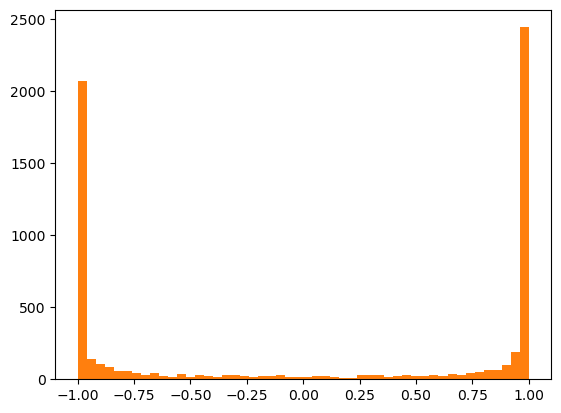

In [32]:

#check pre tanh layer and post tanh layer: h and hpreact

plt.hist(h.view(-1).tolist(), 50);
plt.show()

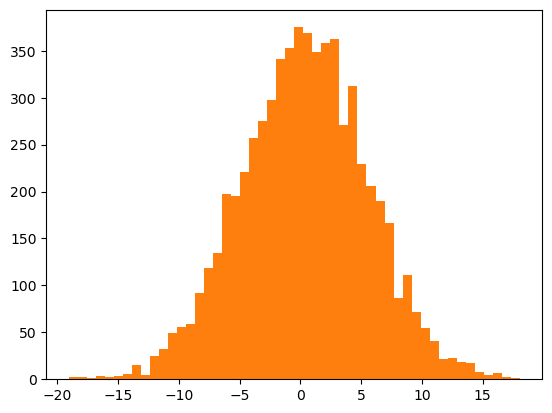

In [34]:
plt.hist(hpreact.view(-1).tolist(), 50);
plt.show()

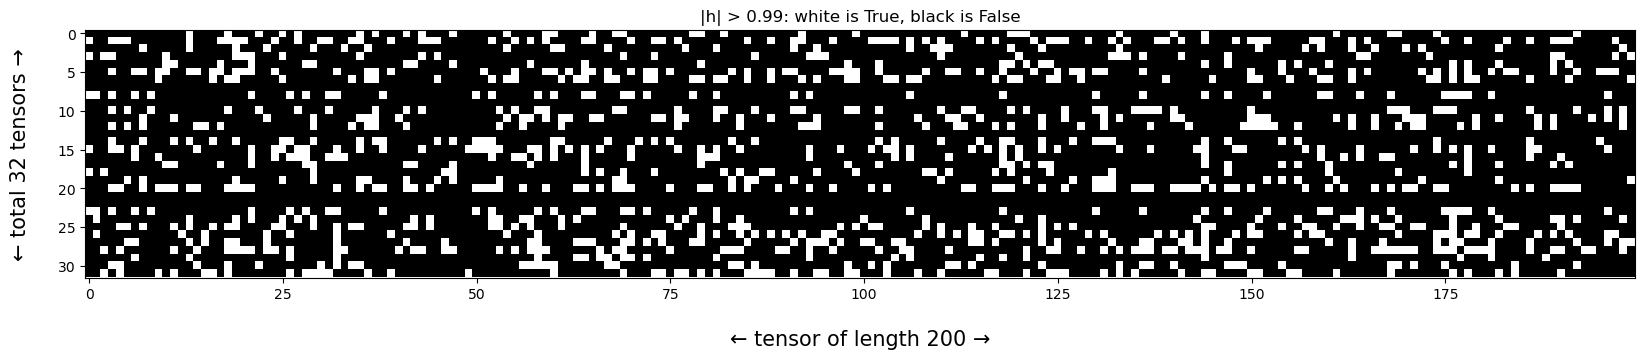

In [58]:
# Show the neurons as white dot with value less than -0.99 or greater than 0.99. 
#This is a boolean tensor. [statement = h.abs() > 0.99]
#White: statement is true
#Black: statement is false

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')
plt.title("|h| > 0.99: white is True, black is False")
plt.xlabel("← tensor of length 200 →", labelpad=20, fontdict={"size":15})
plt.ylabel("← total 32 tensors →", labelpad=20, fontdict={"size":15});
plt.show()

In [37]:
# update hidden layer init value
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [38]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break

      0/ 200000: 3.3135


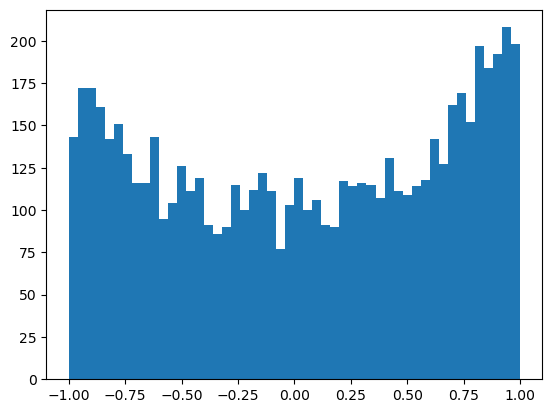

In [39]:
plt.hist(h.view(-1).tolist(), 50);
plt.show()

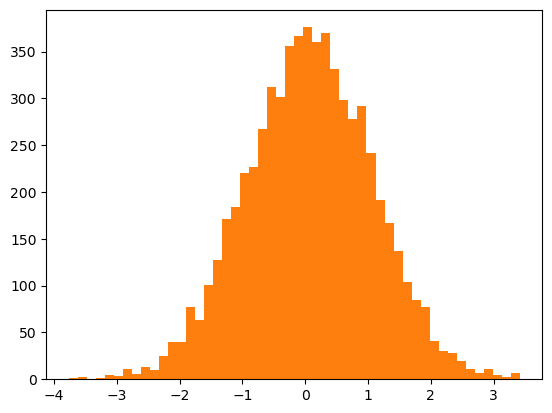

In [41]:
plt.hist(hpreact.view(-1).tolist(), 50);
plt.show()

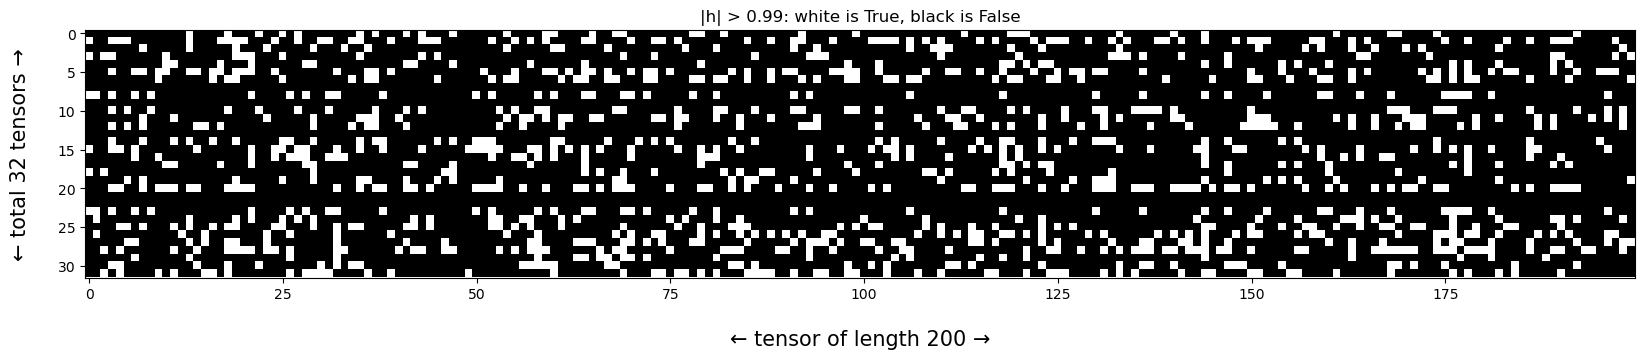

In [56]:
# Show the neurons as white dot with value less than -0.99 or greater than 0.99. 
#This is a boolean tensor. [statement = h.abs() > 0.99]
#White: statement is true
#Black: statement is false

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')
plt.title("|h| > 0.99: white is True, black is False")
plt.xlabel("← tensor of length 200 →", labelpad=20, fontdict={"size":15})
plt.ylabel("← total 32 tensors →", labelpad=20, fontdict={"size":15});
plt.show()

In [44]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [45]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


In [47]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "validation": (Xval, Yval),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("validation")

train loss: 2.0355966091156006
validation loss: 2.1026782989501953


In [48]:
# pre logits init fix:
# train loss: 2.1267659664154053
# validation loss: 2.1697638034820557
# post logits init fix:
# train loss: 2.0695888996124268
# dev loss: 2.131074905395508
# post hidden layer init fix:
# train loss: 2.0355966091156006
# validation loss: 2.1026782989501953


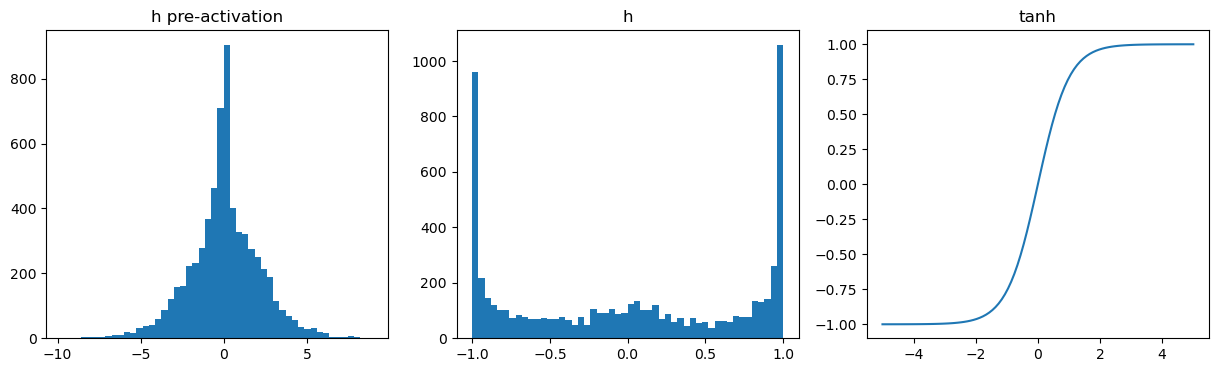

In [55]:
fig, axes = plt.subplots(1, 3, figsize = (15, 4))


axes[0].hist(hpreact.flatten().data, bins = 50)
axes[0].set_title("h pre-activation")

axes[1].hist(h.flatten().data, bins = 50)
axes[1].set_title("h")

axes[2].plot(torch.linspace(-5, 5, 100), torch.tanh(torch.linspace(-5, 5, 100)))
axes[2].set_title("tanh");
plt.show()

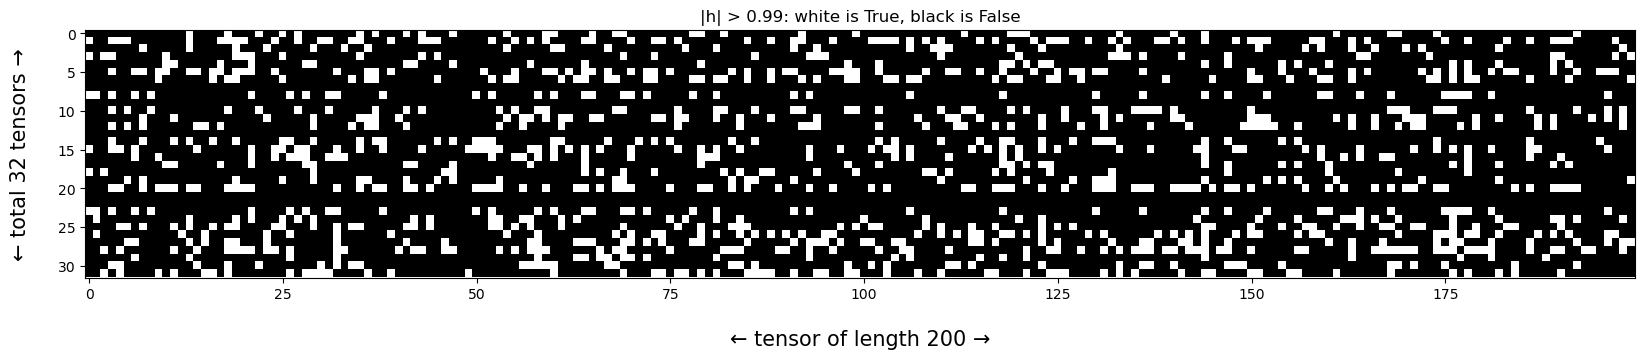

In [51]:
plt.figure(figsize = (20, 10))
plt.imshow(h.abs() > 0.99, cmap = "gray", interpolation='nearest')
plt.title("|h| > 0.99: white is True, black is False")
plt.xlabel("← tensor of length 200 →", labelpad=20, fontdict={"size":15})
plt.ylabel("← total 32 tensors →", labelpad=20, fontdict={"size":15});
plt.show()

tensor(0.0053) tensor(0.9969)
tensor(-0.0023) tensor(0.9874)


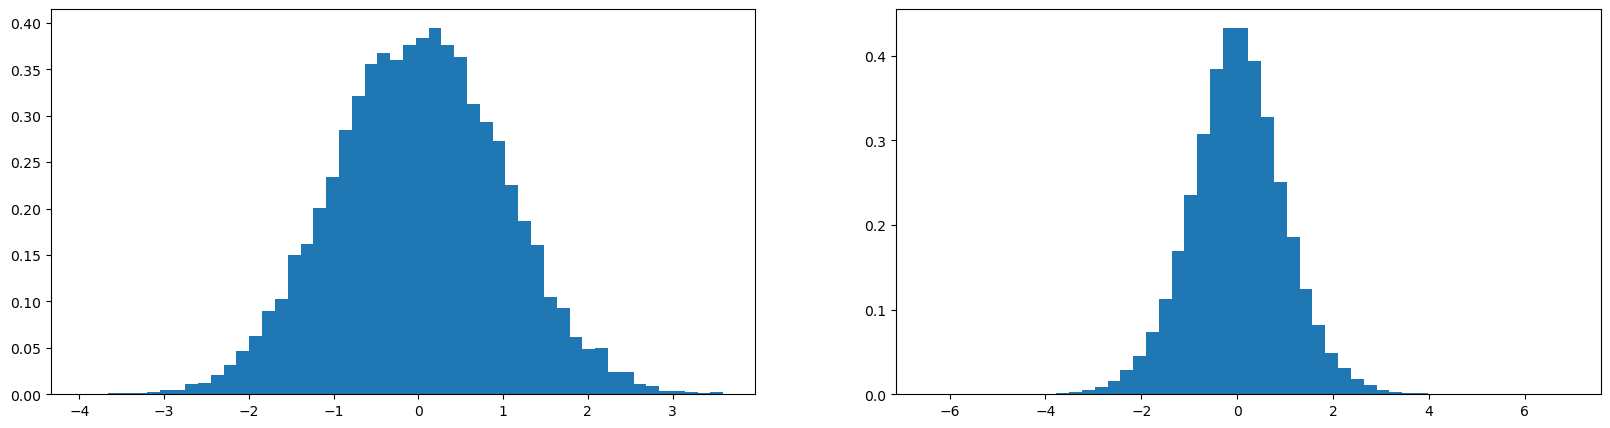

In [54]:
x = torch.randn(1000,10)
W = torch.randn(10,200) / 10**0.5
y = x @ W
print(x.mean(),x.std())
print(y.mean(),y.std())

plt.figure(figsize =(20,5))

plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density = True)

plt.subplot(122)
plt.hist(y.view(-1).tolist(),50, density = True);
plt.show()

In [68]:
(torch.randn(10000) * 0.2).std()


tensor(0.2029)

In [69]:
(5/3) / (30**0.5)

0.3042903097250923

In [70]:
torch.nn.init.calculate_gain('tanh')

1.6666666666666667

In [ ]:
#
# kaiming init
#

# (5/3) / ((n_embd * block_size)**0.5)
# (5/3) — it’s a known correction factor for the tanh activation function.

# For ReLU, good scaling factor ≈ √2
# For tanh, good scaling factor ≈ 5/3 (≈ 1.666…)

In [71]:
# kaiming init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

11897


In [72]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9751
 190000/ 200000: 1.8614


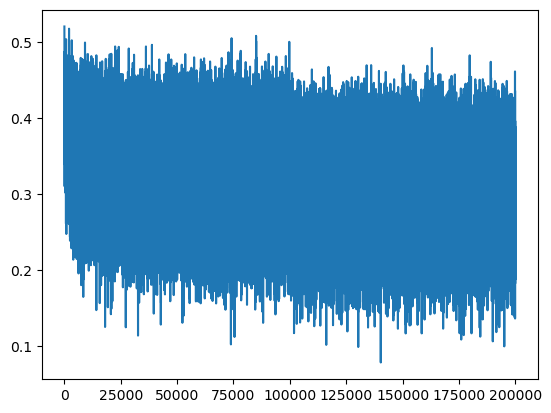

In [73]:
plt.plot(lossi)
plt.show()

In [74]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "validation": (Xval, Yval),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("validation")

train loss: 2.0376641750335693
validation loss: 2.106989622116089


In [83]:
# pre logits init fix:
# train loss: 2.1267659664154053
# validation loss: 2.1697638034820557
# post logits init fix:
# train loss: 2.0695888996124268
# dev loss: 2.131074905395508
# post hidden layer saturated tanh init fix:
# train loss: 2.0355966091156006
# validation loss: 2.1026782989501953
# Kaiming init:
# train loss: 2.0376641750335693
# validation loss: 2.106989622116089

In [75]:
#
# Batch Normalization
#

In [80]:
# normalize the neuron's pre-activation across one mini-batch

In [77]:
hpreact.shape

torch.Size([32, 200])

In [78]:
hpreact.mean(0, keepdim=True).shape, \
hpreact.std(0, keepdim=True).shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [79]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True

12297


In [81]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    # batch norm!
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


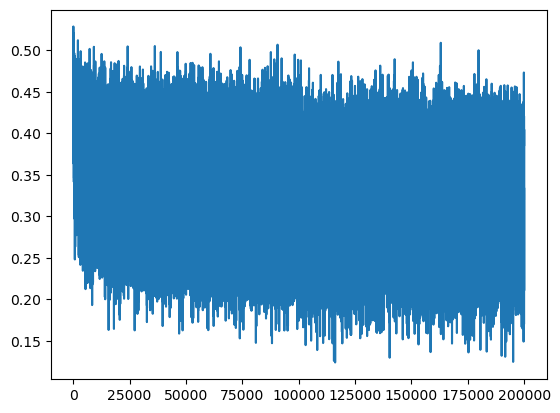

In [82]:
plt.plot(lossi)
plt.show()

In [84]:
torch.tensor(lossi).view(-1, 10000).mean(1)

tensor([0.3693, 0.3514, 0.3461, 0.3428, 0.3398, 0.3386, 0.3372, 0.3360, 0.3350,
        0.3345, 0.3225, 0.3219, 0.3209, 0.3208, 0.3210, 0.3195, 0.3198, 0.3199,
        0.3192, 0.3190])

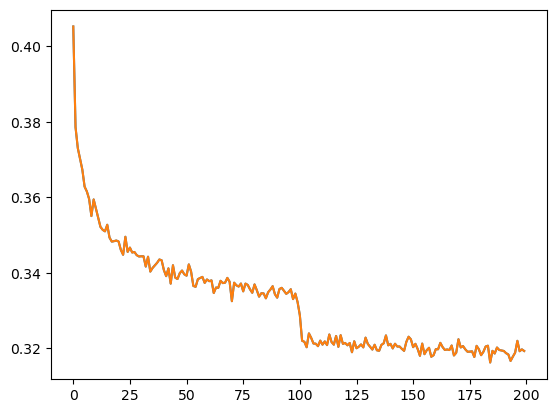

In [86]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));
plt.show()

In [87]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "validation": (Xval, Yval),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("validation")

train loss: 2.0668270587921143
validation loss: 2.104844808578491


In [ ]:
# pre logits init fix:
# train loss: 2.1267659664154053
# validation loss: 2.1697638034820557
# post logits init fix:
# train loss: 2.0695888996124268
# dev loss: 2.131074905395508
# post hidden layer saturated tanh init fix:
# train loss: 2.0355966091156006
# validation loss: 2.1026782989501953
# Kaiming init:
# train loss: 2.0376641750335693
# validation loss: 2.106989622116089
# batch norm
# train loss: 2.0668270587921143
# validation loss: 2.104844808578491

In [88]:
with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [89]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "validation": (Xval, Yval),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
#     hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias

    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("validation")


train loss: 2.066890239715576
validation loss: 2.1049015522003174


In [90]:

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)       # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))        # number of parameters in total

for p in parameters:
      p.requires_grad = True


12297


In [91]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                        # batch X, Y

    # forward pass
    emb = C[Xb]                                      # embed characters into vector space
    embcat = emb.view((emb.shape[0], -1))            # flatten (concatenate the vectors)
    hpreact = embcat @ W1 + b1                       # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi  + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)                          # hidden layer activation
    logits = h @ W2 + b2                             # output layer 
    loss = F.cross_entropy(logits, Yb)               # cross-entropy loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01                 # step learning rate decay
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:                               # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


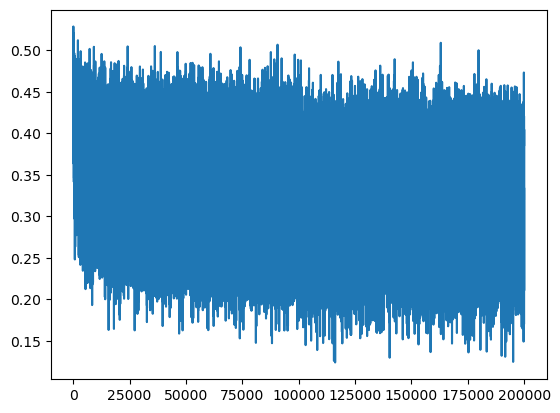

In [92]:
plt.plot(lossi)
plt.show()


In [93]:
torch.tensor(lossi).view(-1, 10000).mean(1)


tensor([0.3693, 0.3514, 0.3461, 0.3428, 0.3398, 0.3386, 0.3372, 0.3360, 0.3350,
        0.3345, 0.3225, 0.3219, 0.3209, 0.3208, 0.3210, 0.3195, 0.3198, 0.3199,
        0.3192, 0.3190])

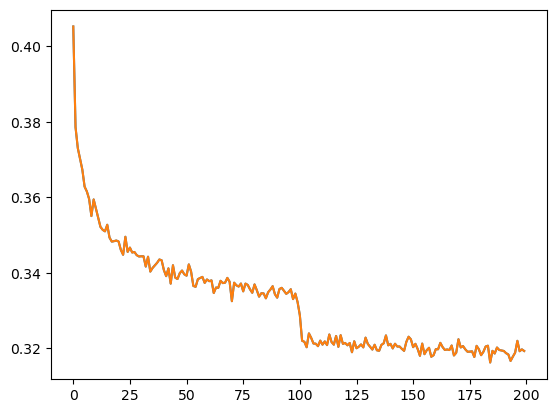

In [95]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));
plt.show()

In [96]:
# fairly similar mean and std values for batchnorm and batchnorm_running 
(bnmean - bnmean_running).mean(), (bnstd - bnstd_running).mean()

(tensor(0.0012), tensor(0.0231))

In [98]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        "train": (Xtr, Ytr),
        "validation": (Xval, Yval),
        "test": (Xte, Yte),
    }[split]

    emb = C[x]                                        # (N, block_size, n_embd)
    embcat = emb.view((emb.shape[0], -1))             # (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1                        # (N, n_hidden)
#     hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)                           # (N, n_hidden)
    logits = h @ W2 + b2                              # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item()}")

split_loss("train")
split_loss("validation")

train loss: 2.06659197807312
validation loss: 2.1050572395324707
